In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [43]:
df=pd.read_csv('data.csv')
df.head()

,SLQ050,SLQ030,SLQ310,SLQ320,SLQ330,SLQ040,SLQ120,OHDEXSTS,DRDINT,DR2DRSTZ,...,DR1TP184,DR1TP204,DR1TP205,DR1TP225,DR1TP226,DR1_320Z,DR1_330Z,DR1BWATZ,SLD012,SLD013
0,0,2,7:00,23:00,7:00,0,0,1,2,1,...,0.0,0.014,0.001,0.001,0.001,315.0,315.0,0.0,8.0,8.0
1,0,9,6:30,22:30,6:30,0,2,1,2,1,...,0.0,0.038,0.001,0.004,0.000,2160.0,720.0,1440.0,8.0,8.0
2,1,2,5:00,23:00,8:00,1,3,1,2,1,...,0.0,0.254,0.004,0.020,0.062,1902.0,1902.0,0.0,7.0,9.0
3,0,1,7:00,1:00,10:00,1,2,1,2,1,...,0.0,0.161,0.003,0.030,0.001,1014.0,0.0,1014.0,7.5,9.0
4,1,0,4:00,23:00,6:00,0,2,1,2,1,...,0.0,0.102,0.006,0.009,0.002,0.0,0.0,0.0,5.5,7.0


In [44]:
for column in tqdm(list(df.columns[df.isnull().sum() > 0])):
    if type(df[column][0])==str:
        df[column].fillna(method='backfill',axis=0, inplace=True)
    else:
        # print(column)
        mean_val = df[column].mean()
        df[column].fillna(mean_val, inplace=True)

100%|██████████| 143/143 [00:00<00:00, 394.19it/s]


In [45]:
drop_index=df[df['SLQ310']=='99999'].index
print(len(df))
df.drop(drop_index,axis=0,inplace=True)
print(len(df))
drop_index=df[df['SLQ320']=='99999'].index
print(len(df))
df.drop(drop_index,axis=0,inplace=True)
print(len(df))
drop_index=df[df['SLQ330']=='99999'].index
print(len(df))
df.drop(drop_index,axis=0,inplace=True)
print(len(df))

4767
4754
4754
4737
4737
4737


In [46]:
def get_time(df,index):
    time_list=[]
    for i in df[index].values.tolist():
        hour=int(i.split(':')[0])
        minute=int(i.split(':')[1])
        time=hour*60+minute
        time_list.append(time)
    return time_list
df['SLQ310']=get_time(df,index='SLQ310')
df['SLQ320']=get_time(df,index='SLQ320')
df['SLQ330']=get_time(df,index='SLQ330')

In [47]:
train_cols=df.columns[1:]
X=df[train_cols]
Y=df['SLQ050']

#scaler
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)
x_train,x_test,y_train,y_test=train_test_split(X_scaled,Y,random_state=0,shuffle=True)
print('Train:',x_train.shape,y_train.shape)
print('Test:',x_test.shape,y_test.shape)

Train: (3552, 360) (3552,)
Test: (1185, 360) (1185,)


In [48]:
for c in np.arange(0.1,2,0.2):
    model=LogisticRegression(solver='newton-cg',
                             max_iter=500,
                             C=c)
    model.fit(x_train,y_train)
    pred=model.predict(x_test)
    print('C:{:.2f}'.format(c),'Accuracy:{:.2%}'.format(accuracy_score(y_test,pred)))

C:0.10 Accuracy:72.07%
C:0.30 Accuracy:73.25%
C:0.50 Accuracy:73.25%
C:0.70 Accuracy:73.42%
C:0.90 Accuracy:73.59%
C:1.10 Accuracy:73.33%
C:1.30 Accuracy:73.33%
C:1.50 Accuracy:73.00%
C:1.70 Accuracy:73.08%
C:1.90 Accuracy:72.74%


In [49]:
model=RandomForestClassifier(n_estimators=300)
model.fit(x_train,y_train)
pred=model.predict(x_test)
weight=model.feature_importances_

In [50]:
df2=pd.DataFrame({'Feature':df.columns[1:],
              'Weight':weight})
new_train_cols=df2.sort_values(by='Weight',ascending=False)['Feature'][:30].values
new_train_cols

array(['HUQ090', 'HUQ051', 'RXDUSE', 'SLQ120', 'BMXWAIST', 'RIDAGEYR',
       'BMXBMI', 'SLQ040', 'BMXWT', 'DLQ040', 'SLD013', 'BMXARMC',
       'LBXVIDMS', 'LBXVD3MS', 'LBXHSCRP', 'URXVOL1', 'WTDR2D',
       'LBXMCVSI', 'LBDBMNSI', 'DR1TATOC', 'WTINT2YR', 'WTDRD1', 'LBXBSE',
       'LBXPLTSI', 'DR1TSUGR', 'LBXRBCSI', 'LBXLYPCT', 'WTMEC2YR',
       'URXUMA', 'DR1TCOPP'], dtype=object)

In [51]:
len(weight)

360

Text(0, 0.5, 'Importance')

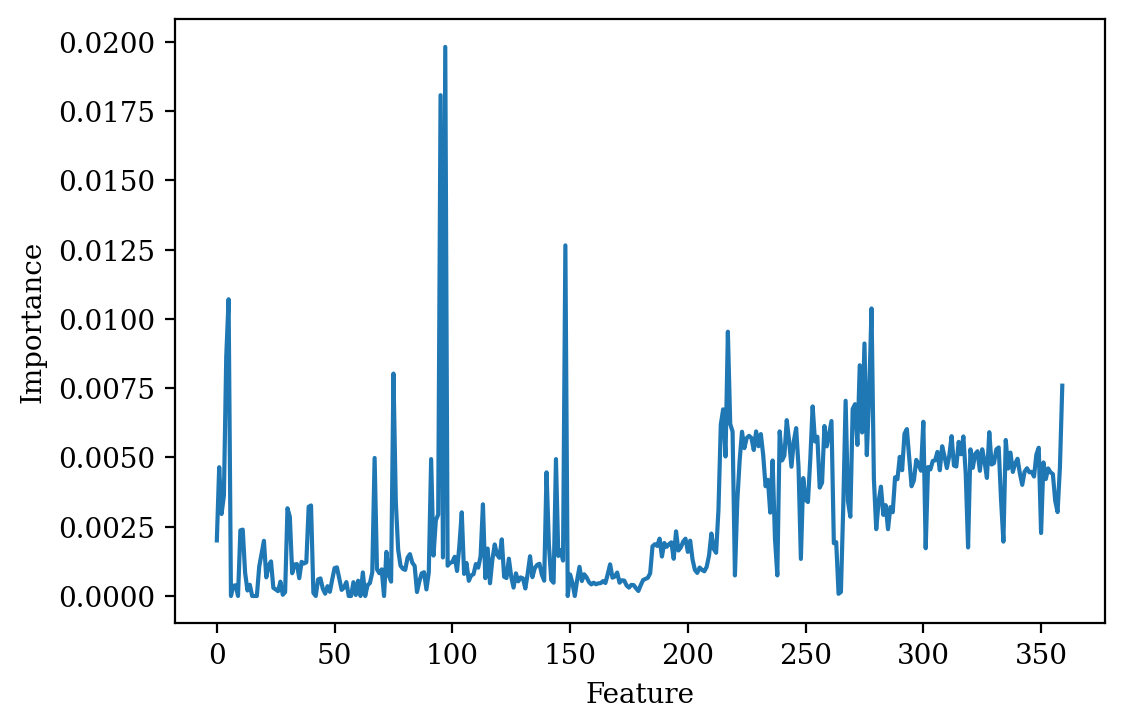

In [52]:
plt.rcParams['font.family']='serif'
plt.figure(dpi=200)
plt.plot(model.feature_importances_)
plt.xlabel('Feature')
plt.ylabel('Importance')

In [53]:

X=df[new_train_cols]
Y=df['SLQ050']

#scaler
scaler=MinMaxScaler()
X_scaled=scaler.fit_transform(X)
x_train,x_test,y_train,y_test=train_test_split(X_scaled,Y,random_state=0,shuffle=True)
print('Train:',x_train.shape,y_train.shape)
print('Test:',x_test.shape,y_test.shape)

for c in np.arange(0.1,2,0.2):
    model=LogisticRegression(solver='newton-cg',
                             max_iter=500,
                             C=c)
    model.fit(x_train,y_train)
    pred=model.predict(x_test)
    print('C:{:.2f}'.format(c),'Accuracy:{:.2%}'.format(accuracy_score(y_test,pred)))

Train: (3552, 30) (3552,)
Test: (1185, 30) (1185,)
C:0.10 Accuracy:70.97%
C:0.30 Accuracy:71.56%
C:0.50 Accuracy:72.24%
C:0.70 Accuracy:72.57%
C:0.90 Accuracy:72.74%
C:1.10 Accuracy:73.08%
C:1.30 Accuracy:73.00%
C:1.50 Accuracy:73.00%
C:1.70 Accuracy:73.08%
C:1.90 Accuracy:73.16%


In [54]:
oversampler=SMOTE(random_state=0)
os_features,os_labels=oversampler.fit_resample(x_train,y_train)
print('Before Sample:',x_train.shape)
print('After Sample:',os_features.shape)
os_labels.value_counts()

Before Sample: (3552, 30)
After Sample: (5158, 30)


1    2579
0    2579
Name: SLQ050, dtype: int64

In [55]:
x_train,x_test,y_train,y_test=train_test_split(os_features,os_labels,random_state=0,shuffle=True,test_size=0.2)

model=RandomForestClassifier(n_estimators=300,random_state=4)
model.fit(x_train,y_train)
pred=model.predict(x_test)
accuracy_score(pred,y_test)

0.8682170542635659

In [56]:
#Neural Network
print(x_train.shape,y_train.shape)
print(type(x_train),type(y_train))

import pandas as pd
import numpy as np
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler,Normalizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import datetime
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import time

(4126, 30) (4126,)
<class 'numpy.ndarray'> <class 'pandas.core.series.Series'>


In [57]:
class MoneyDataset(Dataset):
    def __init__(self,x,y):
        self.data=x
        self.label=y
    def __len__(self):
        return len(self.label)
    def __getitem__(self, item):
        data_value=torch.FloatTensor(self.data[item])
        label_value=torch.LongTensor([self.label[item]])
        return data_value,label_value

train_loader=DataLoader(MoneyDataset(x_train,y_train.values),batch_size=16)
valid_loader=DataLoader(MoneyDataset(x_test,y_test.values),batch_size=16)

for x,y in valid_loader:
    print(x.shape)
    print(y.shape)
    break

torch.Size([16, 30])
torch.Size([16, 1])


In [58]:
loss_f=nn.CrossEntropyLoss()
device='cpu'

In [59]:
class BP(nn.Module):
    def __init__(self,input_dim=30,output_dim=2):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(input_dim,1024),
            nn.LeakyReLU(),
            nn.Linear(1024,512),
            nn.LayerNorm(512),
            nn.LeakyReLU(),
            nn.Linear(512,256),
            nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(256,128),
             nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(128,32),

            nn.LeakyReLU(),
            nn.Linear(32,output_dim),

        )
    def forward(self,x):
        return self.model(x)
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

model=BP()
model.to(device)

optimizer=optim.Adam(model.parameters(),lr=0.001)

In [72]:
from tqdm import tqdm
N_epoch=100
best_loss=9999
par=tqdm(range(N_epoch))

train_acc_list=[]
valid_acc_list=[]
for i in par:
    epoch_loss=0
    epoch_loss_v=0
    epoch_acc=0
    epoch_acc_v=0

    for data,label in train_loader:
        data=data.to(device)
        label=label.to(device)
        optimizer.zero_grad()
        pre=model(data)
        loss=loss_f(pre,label.reshape(-1))
        loss.backward()
        optimizer.step()
        epoch_loss=epoch_loss+loss.item()
        epoch_acc=epoch_acc+categorical_accuracy(pre,label)

    with torch.no_grad():
        for data,label in valid_loader:
            data=data.to(device)
            label=label.to(device)
            pre=model(data)
            loss=loss_f(pre,label.reshape(-1))
            epoch_loss_v=epoch_loss_v+loss.item()
            epoch_acc_v=epoch_acc_v+categorical_accuracy(pre,label)
    if epoch_loss_v/len(valid_loader)<best_loss:
        # print('Save Model..')
        best_loss=epoch_loss_v/len(valid_loader)
        torch.save(model.state_dict(),'BP.pth')

    # print(f'Epoch: {i+1:02} | ')
    # print(f'\tTrain Loss: {epoch_loss/len(train_loader):.3f} | Valid Loss: {epoch_loss_v/len(valid_loader):.3f}')
    # print(f'\tTrain Accuracy: {epoch_acc*100/len(train_loader):.3f}% | Valid Accuracy: {epoch_acc_v*100/len(valid_loader):.3f}%')
    train_acc_list.append(epoch_acc*100/len(train_loader))
    valid_acc_list.append(epoch_acc_v*100/len(valid_loader))
    par.set_description_str(f'Epoch: {i+1:02}')
    par.set_postfix_str(f'Train Accuracy: {epoch_acc*100/len(train_loader):.3f}% | Valid Accuracy: {epoch_acc_v*100/len(valid_loader):.3f}%')

Epoch: 100: 100%|██████████| 100/100 [02:55<00:00,  1.76s/it, Train Accuracy: 98.740% | Valid Accuracy: 83.942%]


In [80]:
train_acc_list=[train_acc_list[i].cpu().numpy() for i in range(len(train_acc_list))]
valid_acc_list=[valid_acc_list[i].cpu().numpy() for i in range(len(valid_acc_list))]

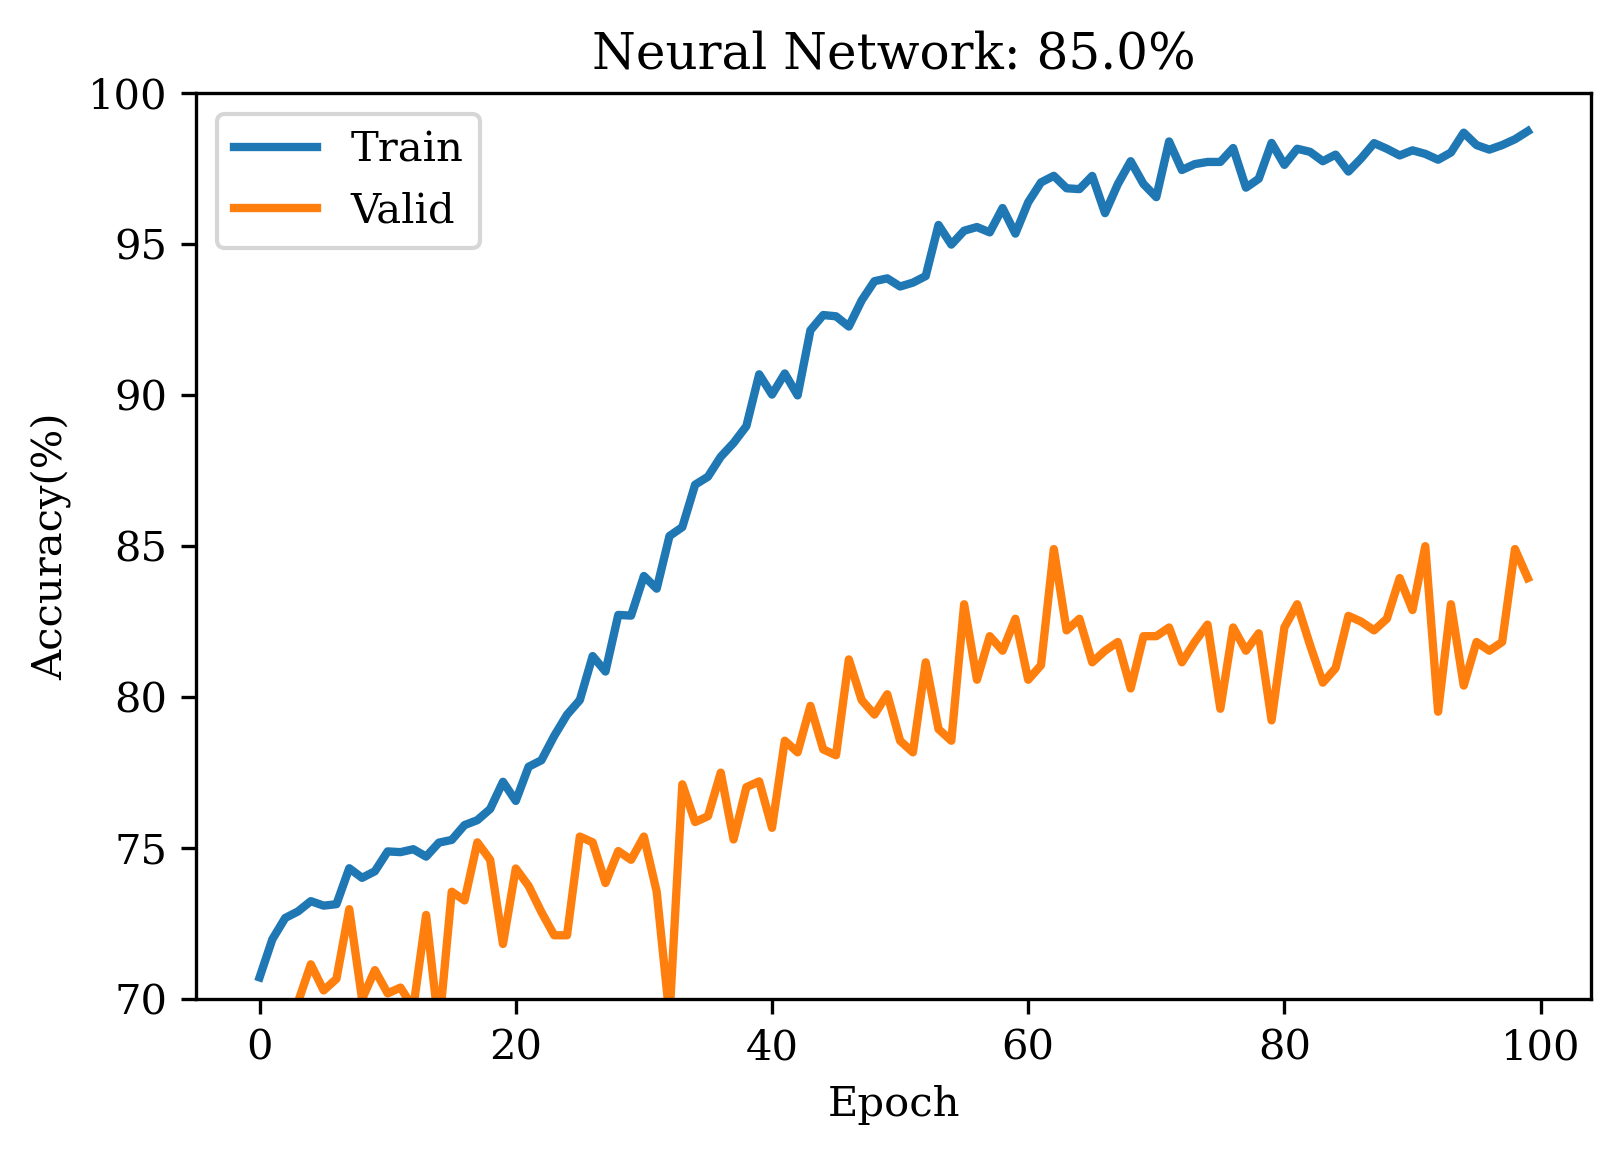

In [90]:
plt.rcParams['font.family']='serif'
plt.figure(dpi=300)
plt.title(f'Neural Network: {max(valid_acc_list)}%')
plt.plot(range(len(train_acc_list)),train_acc_list,label='Train',lw=2)
plt.plot(range(len(valid_acc_list)),valid_acc_list,label='Valid',lw=2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.ylim(70,100)
plt.legend()
plt.savefig('Acc.jpg')